## Setup


In [1]:
import numpy as np
import os
from typing import List, Tuple, Sequence

from type_definitions.test_case import TestCase_ACAS
from type_definitions.test_result import TestResult_ACAS
from type_definitions.utils import (
    generate_cases_acasxu,
    evaluate_cases_acasxu,
    pairwise_distances,
    dtw_distance,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import stats
import cma

## Simulation


In [2]:
seed = 100
use_cached_distance_matrix = True
n_cases = 400

np.random.seed(seed)

print(f"Generating {n_cases} ACASXU F-16 test cases...")
cases = generate_cases_acasxu(n_cases)
print(f"Evaluating cases (this may take a while)...")
results = evaluate_cases_acasxu(cases)

valid_results = [r for r in results if not r.simulation_failed]
trajectories = [r.trajectory for r in valid_results]

print(f"\nGenerated {len(trajectories)} valid trajectories out of {n_cases}")
print(f"Crashed: {sum(1 for r in valid_results if r.crashed)}")
print(f"Safe: {sum(1 for r in valid_results if not r.crashed)}")

Generating 400 ACASXU F-16 test cases...
Evaluating cases (this may take a while)...

Generated 312 valid trajectories out of 400
Crashed: 120
Safe: 192


In [3]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = (
    f"cache/acasxu_f16_distance_matrix_seed{seed}_size{len(trajectories)}.npy"
)

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise DTW distances (this may take a while)...")
    distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Calculating pairwise DTW distances (this may take a while)...
Distance matrix saved to cache/acasxu_f16_distance_matrix_seed100_size312.npy
Distance matrix shape: (312, 312)


## Training Utility Functions


In [4]:
def testcase_to_ndarray(test_case: TestCase_ACAS) -> np.ndarray:
    """Convert ACASXU F-16 test case to numpy array (14 features).

    Features: [ownship_vt, ownship_alpha, ownship_beta, ownship_phi, ownship_theta, ownship_alt,
               intruder_vt, intruder_alpha, intruder_beta, intruder_phi, intruder_theta, intruder_alt,
               rel_pos_n, rel_pos_e]

    Note: We exclude psi (always 0) and use relative position instead of absolute.
    """
    return np.array(
        [
            # Ownship parameters (excluding psi which is always 0)
            test_case.ownship_vt,
            test_case.ownship_alpha,
            test_case.ownship_beta,
            test_case.ownship_phi,
            test_case.ownship_theta,
            test_case.ownship_alt,
            # Intruder parameters (excluding psi which is always 0)
            test_case.intruder_vt,
            test_case.intruder_alpha,
            test_case.intruder_beta,
            test_case.intruder_phi,
            test_case.intruder_theta,
            test_case.intruder_alt,
            # Relative position (separation)
            test_case.intruder_pos_n - test_case.ownship_pos_n,
            test_case.intruder_pos_e - test_case.ownship_pos_e,
        ]
    )


def ndarray_to_testcase(arr: np.ndarray) -> TestCase_ACAS:
    """Convert numpy array back to TestCase_ACAS.

    Note: We set ownship at origin and intruder at relative position.
    psi is fixed at 0 for both aircraft.
    """
    return TestCase_ACAS(
        ownship_vt=float(arr[0]),
        ownship_alpha=float(arr[1]),
        ownship_beta=float(arr[2]),
        ownship_phi=float(arr[3]),
        ownship_theta=float(arr[4]),
        ownship_psi=0.0,  # Fixed at 0
        ownship_alt=float(arr[5]),
        ownship_power=9.0,  # Fixed
        ownship_pos_n=0.0,
        ownship_pos_e=0.0,
        intruder_vt=float(arr[6]),
        intruder_alpha=float(arr[7]),
        intruder_beta=float(arr[8]),
        intruder_phi=float(arr[9]),
        intruder_theta=float(arr[10]),
        intruder_psi=0.0,  # Fixed at 0
        intruder_alt=float(arr[11]),
        intruder_power=9.0,  # Fixed
        intruder_pos_n=float(arr[12]),
        intruder_pos_e=float(arr[13]),
    )


# Define feature bounds based on generate_single_case_acasxu ranges
# [ownship: vt, alpha, beta, phi, theta, alt]
# [intruder: vt, alpha, beta, phi, theta, alt]
# [rel_pos_n, rel_pos_e]
# Note: psi excluded (always 0)
BOUNDS_LOWER = np.array(
    [
        400,  # ownship_vt
        np.deg2rad(0),  # ownship_alpha
        np.deg2rad(-20),  # ownship_beta
        np.deg2rad(-180),  # ownship_phi
        np.deg2rad(-90),  # ownship_theta
        500,  # ownship_alt
        400,  # intruder_vt
        np.deg2rad(0),  # intruder_alpha
        np.deg2rad(-20),  # intruder_beta
        np.deg2rad(-180),  # intruder_phi
        np.deg2rad(-90),  # intruder_theta
        500,  # intruder_alt
        10000,  # rel_pos_n
        -10000,  # rel_pos_e
    ],
)

BOUNDS_UPPER = np.array(
    [
        800,  # ownship_vt
        np.deg2rad(10),  # ownship_alpha
        np.deg2rad(20),  # ownship_beta
        np.deg2rad(180),  # ownship_phi
        np.deg2rad(0),  # ownship_theta
        6000,  # ownship_alt
        800,  # intruder_vt
        np.deg2rad(10),  # intruder_alpha
        np.deg2rad(20),  # intruder_beta
        np.deg2rad(180),  # intruder_phi
        np.deg2rad(0),  # intruder_theta
        6000,  # intruder_alt
        40000,  # rel_pos_n
        10000,  # rel_pos_e
    ],
)

# Per-feature ranges for normalized squared diffs
FEATURE_RANGE = BOUNDS_UPPER - BOUNDS_LOWER

# Angular indices for proper angle difference calculation
# [alpha, beta, phi, theta] for both aircraft (indices in 14-dim space)
ANGULAR_INDICES = [1, 2, 3, 4, 7, 8, 9, 10]

print(f"Feature dimensions: {len(BOUNDS_LOWER)}")
print(f"Bounds check - all lower < upper: {np.all(BOUNDS_LOWER < BOUNDS_UPPER)}")
print(f"Angular feature indices: {ANGULAR_INDICES}")
print(f"Feature range min: {FEATURE_RANGE.min():.4f}, max: {FEATURE_RANGE.max():.4f}")

Feature dimensions: 14
Bounds check - all lower < upper: True
Angular feature indices: [1, 2, 3, 4, 7, 8, 9, 10]
Feature range min: 0.1745, max: 30000.0000


In [5]:
def pair_features_between(feat1: np.ndarray, feat2: np.ndarray) -> np.ndarray:
    """Create pairwise features between two test case feature vectors.

    Returns: concatenated [diff, abs_diff, norm_diff_sq, euclidean_dist, angular_diffs, interaction_features]
    """
    feat_diff = feat1 - feat2
    feat_abs_diff = np.abs(feat_diff)
    euclidean_dist = np.linalg.norm(feat_diff)

    # Normalized squared differences for all features (scale-invariant)
    norm_diff_sq = (feat_diff / FEATURE_RANGE) ** 2

    # Proper angular differences (wrap to [-pi, pi])
    angular_diffs = []
    for idx in ANGULAR_INDICES:
        diff = feat_diff[idx]
        diff = (diff + np.pi) % (2 * np.pi) - np.pi
        angular_diffs.append(diff)

    # Additional features for better prediction
    # 1. Velocity difference (important for trajectory divergence)
    vt_diff = feat1[0] - feat2[0]  # ownship vt diff
    vt_int_diff = feat1[6] - feat2[6]  # intruder vt diff

    # 2. Altitude difference (highly correlated with trajectory distance)
    alt_diff = feat1[5] - feat2[5]  # ownship alt
    alt_int_diff = feat1[11] - feat2[11]  # intruder alt

    # 3. Relative position differences
    rel_n_diff = feat1[12] - feat2[12]
    rel_e_diff = feat1[13] - feat2[13]
    rel_pos_euclidean = np.sqrt(rel_n_diff**2 + rel_e_diff**2)
    rel_pos_norm1 = np.sqrt(feat1[12] ** 2 + feat1[13] ** 2)
    rel_pos_norm2 = np.sqrt(feat2[12] ** 2 + feat2[13] ** 2)
    rel_pos_norm_diff = np.abs(rel_pos_norm1 - rel_pos_norm2)
    rel_bearing1 = np.arctan2(feat1[13], feat1[12])
    rel_bearing2 = np.arctan2(feat2[13], feat2[12])
    rel_bearing_diff = (rel_bearing1 - rel_bearing2 + np.pi) % (2 * np.pi) - np.pi

    # 4. Interaction terms (products of key differences)
    vt_alt_interaction = np.abs(vt_diff) * np.abs(alt_diff) / 1e6  # Scaled
    angle_vt_interaction = np.sum(np.abs(angular_diffs[:4])) * np.abs(vt_diff) / 1e3

    # 5. Squared differences for non-linearity (key dims)
    vt_diff_sq = vt_diff**2 / 1e6
    alt_diff_sq = alt_diff**2 / 1e6

    # Key min/max features (velocity, altitude, relative position)
    min_vt = min(feat1[0], feat2[0])
    max_vt = max(feat1[0], feat2[0])
    min_alt = min(feat1[5], feat2[5])
    max_alt = max(feat1[5], feat2[5])

    combined = np.concatenate(
        [
            feat_diff,  # 14 features
            feat_abs_diff,  # 14 features
            norm_diff_sq,  # 14 features (normalized squared diffs)
            [euclidean_dist],  # 1 feature
            angular_diffs,  # 8 features (angles)
            # New features
            [vt_diff, vt_int_diff, alt_diff, alt_int_diff],  # 4 features
            [
                rel_pos_euclidean,
                rel_pos_norm1,
                rel_pos_norm2,
                rel_pos_norm_diff,
            ],  # 4 features
            [rel_bearing_diff],  # 1 feature
            [vt_alt_interaction, angle_vt_interaction],  # 2 features
            [vt_diff_sq, alt_diff_sq],  # 2 features
            [min_vt, max_vt, min_alt, max_alt],  # 4 features
        ]
    )

    return combined


def create_pairwise_features(
    features: np.ndarray,
    distance_matrix: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """Create pairwise feature matrix and corresponding distances.

    Args:
        features: (n_samples, n_features) array of test case features
        distance_matrix: (n_samples, n_samples) pairwise distance matrix

    Returns:
        X_pairwise: (n_pairs, pairwise_features) feature matrix
        y_pairwise: (n_pairs,) distance labels
    """
    n = features.shape[0]
    pairwise_features = []
    distances = []

    for i in range(n):
        for j in range(i + 1, n):
            pair_feat = pair_features_between(features[i], features[j])
            pairwise_features.append(pair_feat)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)

## Convert Test Cases to Features


In [6]:
# Convert all valid test cases to feature arrays
features = np.array([testcase_to_ndarray(r.test_case) for r in valid_results])
print(f"Features shape: {features.shape}")

# Print feature statistics (updated for 14 features, no psi)
feature_names = [
    "own_vt",
    "own_alpha",
    "own_beta",
    "own_phi",
    "own_theta",
    "own_alt",
    "int_vt",
    "int_alpha",
    "int_beta",
    "int_phi",
    "int_theta",
    "int_alt",
    "rel_pos_n",
    "rel_pos_e",
]

print("\nFeature statistics:")
for i, name in enumerate(feature_names):
    print(
        f"  {name:12s}: min={features[:, i].min():10.2f}, max={features[:, i].max():10.2f}, mean={features[:, i].mean():10.2f}"
    )

# Pairwise feature names for analysis
pairwise_feature_names = (
    [f"{n}_diff" for n in feature_names]  # 14
    + [f"{n}_abs_diff" for n in feature_names]  # 14
    + [f"{n}_diff_sq_norm" for n in feature_names]  # 14
    + ["euclidean_dist"]  # 1
    + [
        "alpha_ang",
        "beta_ang",
        "phi_ang",
        "theta_ang",
        "int_alpha_ang",
        "int_beta_ang",
        "int_phi_ang",
        "int_theta_ang",
    ]  # 8
    + ["vt_diff2", "vt_int_diff2", "alt_diff2", "alt_int_diff2"]  # 4 (new)
    + ["rel_pos_euc", "rel_pos_norm1", "rel_pos_norm2", "rel_pos_norm_diff"]  # 4 (new)
    + ["rel_bearing_diff"]  # 1 (new)
    + ["vt_alt_inter", "ang_vt_inter"]  # 2 (new)
    + ["vt_diff_sq", "alt_diff_sq"]  # 2 (new)
    + ["min_vt", "max_vt", "min_alt", "max_alt"]  # 4 (new)
)
print(f"\nTotal pairwise features: {len(pairwise_feature_names)}")

Features shape: (312, 14)

Feature statistics:
  own_vt      : min=    407.96, max=    798.14, mean=    622.04
  own_alpha   : min=      0.00, max=      0.17, mean=      0.09
  own_beta    : min=     -0.35, max=      0.35, mean=     -0.01
  own_phi     : min=     -3.11, max=      3.13, mean=     -0.05
  own_theta   : min=     -1.57, max=     -0.01, mean=     -0.75
  own_alt     : min=    519.39, max=   5985.61, mean=   3255.99
  int_vt      : min=    403.66, max=    799.32, mean=    614.63
  int_alpha   : min=      0.00, max=      0.17, mean=      0.09
  int_beta    : min=     -0.35, max=      0.35, mean=      0.01
  int_phi     : min=     -3.14, max=      3.11, mean=     -0.12
  int_theta   : min=     -1.57, max=     -0.00, mean=     -0.74
  int_alt     : min=    507.69, max=   5997.14, mean=   3137.70
  rel_pos_n   : min=  11289.57, max=  39187.41, mean=  24313.92
  rel_pos_e   : min=  -8927.03, max=   9420.52, mean=    -49.36

Total pairwise features: 68


## Random Forest Distance Predictor


In [7]:
# # Create pairwise features for training
# print("Creating pairwise features...")
# X_pairwise, y_pairwise = create_pairwise_features(features, distance_matrix)
# print(f"Pairwise features shape: {X_pairwise.shape}")
# print(f"Pairwise distances shape: {y_pairwise.shape}")

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_pairwise, y_pairwise, test_size=0.2, random_state=seed
# )

# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print(f"\nTraining set size: {len(X_train)}")
# print(f"Test set size: {len(X_test)}")

In [8]:
# # Apply log transformation to target to handle skewed distance distribution
# print("Analyzing target distribution...")
# print(
#     f"Distance stats: min={y_train.min():.0f}, max={y_train.max():.0f}, mean={y_train.mean():.0f}, median={np.median(y_train):.0f}"
# )

# # Log transform helps when distances have high variance
# y_train_log = np.log1p(y_train)  # log(1 + x) to handle zeros
# y_test_log = np.log1p(y_test)

# print(
#     f"Log distance stats: min={y_train_log.min():.2f}, max={y_train_log.max():.2f}, mean={y_train_log.mean():.2f}"
# )

# # Train multiple models and compare
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
# from sklearn.ensemble import ExtraTreesRegressor

# print("\n" + "=" * 60)
# print("Training models with log-transformed target...")
# print("=" * 60)

# # Model 1: Regularized Random Forest (reduced depth + larger leaves to limit overfit)
# print("\n1. Random Forest (log-transformed target)...")
# rf_model = RandomForestRegressor(
#     n_estimators=250,
#     max_depth=14,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     max_features=0.5,
#     bootstrap=True,
#     max_samples=0.8,
#     random_state=seed,
#     n_jobs=-1,
# )
# rf_model.fit(X_train_scaled, y_train_log)

# y_pred_train_log = rf_model.predict(X_train_scaled)
# y_pred_test_log = rf_model.predict(X_test_scaled)

# # Transform back to original scale
# y_pred_train_rf = np.expm1(y_pred_train_log)
# y_pred_test_rf = np.expm1(y_pred_test_log)

# print(f"  Train R²: {r2_score(y_train, y_pred_train_rf):.4f}")
# print(f"  Test R²:  {r2_score(y_test, y_pred_test_rf):.4f}")

# # Model 2: Regularized Extra Trees (cap depth, larger leaves)
# print("\n2. Extra Trees (log-transformed target)...")
# et_model = ExtraTreesRegressor(
#     n_estimators=300,
#     max_depth=16,
#     min_samples_split=8,
#     min_samples_leaf=4,
#     max_features=0.6,
#     bootstrap=True,
#     max_samples=0.8,
#     random_state=seed,
#     n_jobs=-1,
# )
# et_model.fit(X_train_scaled, y_train_log)

# y_pred_train_log_et = et_model.predict(X_train_scaled)
# y_pred_test_log_et = et_model.predict(X_test_scaled)

# y_pred_train_et = np.expm1(y_pred_train_log_et)
# y_pred_test_et = np.expm1(y_pred_test_log_et)

# print(f"  Train R²: {r2_score(y_train, y_pred_train_et):.4f}")
# print(f"  Test R²:  {r2_score(y_test, y_pred_test_et):.4f}")

# # Model 3: Gradient Boosting with log target
# print("\n3. Gradient Boosting (log-transformed target)...")
# gb_model = GradientBoostingRegressor(
#     n_estimators=400,
#     max_depth=5,
#     learning_rate=0.05,
#     min_samples_split=10,
#     min_samples_leaf=8,
#     subsample=0.8,
#     max_features=0.6,
#     random_state=seed,
# )
# gb_model.fit(X_train_scaled, y_train_log)

# y_pred_train_log_gb = gb_model.predict(X_train_scaled)
# y_pred_test_log_gb = gb_model.predict(X_test_scaled)

# y_pred_train_gb = np.expm1(y_pred_train_log_gb)
# y_pred_test_gb = np.expm1(y_pred_test_log_gb)

# print(f"  Train R²: {r2_score(y_train, y_pred_train_gb):.4f}")
# print(f"  Test R²:  {r2_score(y_test, y_pred_test_gb):.4f}")

# # Model 4: HistGradientBoosting (best accuracy, still fast)
# print("\n4. HistGradientBoosting (log-transformed target)...")
# hgb_model = HistGradientBoostingRegressor(
#     max_iter=450,
#     max_depth=7,
#     learning_rate=0.05,
#     min_samples_leaf=20,
#     l2_regularization=0.3,
#     random_state=seed,
# )
# hgb_model.fit(X_train_scaled, y_train_log)

# y_pred_train_log_hgb = hgb_model.predict(X_train_scaled)
# y_pred_test_log_hgb = hgb_model.predict(X_test_scaled)

# y_pred_train_hgb = np.expm1(y_pred_train_log_hgb)
# y_pred_test_hgb = np.expm1(y_pred_test_log_hgb)

# print(f"  Train R²: {r2_score(y_train, y_pred_train_hgb):.4f}")
# print(f"  Test R²:  {r2_score(y_test, y_pred_test_hgb):.4f}")

# # Select best model based on test R²
# models = {
#     "Random Forest": (
#         rf_model,
#         y_pred_train_rf,
#         y_pred_test_rf,
#         r2_score(y_test, y_pred_test_rf),
#     ),
#     "Extra Trees": (
#         et_model,
#         y_pred_train_et,
#         y_pred_test_et,
#         r2_score(y_test, y_pred_test_et),
#     ),
#     "Gradient Boosting": (
#         gb_model,
#         y_pred_train_gb,
#         y_pred_test_gb,
#         r2_score(y_test, y_pred_test_gb),
#     ),
#     "HistGradientBoosting": (
#         hgb_model,
#         y_pred_train_hgb,
#         y_pred_test_hgb,
#         r2_score(y_test, y_pred_test_hgb),
#     ),
# }

# best_name = max(models.keys(), key=lambda k: models[k][3])
# best_model, y_pred_train, y_pred_test, best_r2 = models[best_name]

# print(f"\n>>> Selected: {best_name} (Test R² = {best_r2:.4f})")

# # Store for later use
# rf_model = best_model

# # Print detailed performance
# print("\n" + "=" * 60)
# print(f"BEST MODEL: {best_name}")
# print("=" * 60)
# print("\nTraining:")
# print(f"  MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
# print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")
# print(f"  R²: {r2_score(y_train, y_pred_train):.4f}")

# print("\nTest:")
# print(f"  MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
# print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
# print(f"  R²: {r2_score(y_test, y_pred_test):.4f}")

In [9]:
# # Plot predicted vs actual
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Training
# axes[0].scatter(y_train, y_pred_train, alpha=0.3, s=5)
# axes[0].plot(
#     [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2
# )
# axes[0].set_xlabel("Actual Distance")
# axes[0].set_ylabel("Predicted Distance")
# axes[0].set_title(f"Training Set (R²={r2_score(y_train, y_pred_train):.3f})")

# # Test
# axes[1].scatter(y_test, y_pred_test, alpha=0.3, s=5)
# axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
# axes[1].set_xlabel("Actual Distance")
# axes[1].set_ylabel("Predicted Distance")
# axes[1].set_title(f"Test Set (R²={r2_score(y_test, y_pred_test):.3f})")

# plt.suptitle("Distance Predictor: Predicted vs Actual", fontsize=12)
# plt.tight_layout()
# plt.show()

# # Also plot residuals to diagnose prediction quality
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# residuals_train = y_train - y_pred_train
# residuals_test = y_test - y_pred_test

# axes[0].scatter(y_pred_train, residuals_train, alpha=0.3, s=5)
# axes[0].axhline(y=0, color="r", linestyle="--")
# axes[0].set_xlabel("Predicted Distance")
# axes[0].set_ylabel("Residual")
# axes[0].set_title("Training Residuals")

# axes[1].scatter(y_pred_test, residuals_test, alpha=0.3, s=5)
# axes[1].axhline(y=0, color="r", linestyle="--")
# axes[1].set_xlabel("Predicted Distance")
# axes[1].set_ylabel("Residual")
# axes[1].set_title("Test Residuals")

# plt.tight_layout()
# plt.show()

In [10]:
# # Feature importance analysis
# print("\n" + "=" * 60)
# print("FEATURE IMPORTANCE ANALYSIS")
# print("=" * 60)

# # Get feature importance from the best model
# if hasattr(rf_model, "feature_importances_"):
#     importances = rf_model.feature_importances_

#     # Sort by importance
#     indices = np.argsort(importances)[::-1]

#     print("\nTop 15 Most Important Features:")
#     for i, idx in enumerate(indices[:15]):
#         if idx < len(pairwise_feature_names):
#             print(
#                 f"  {i+1:2d}. {pairwise_feature_names[idx]:20s}: {importances[idx]:.4f}"
#             )
#         else:
#             print(f"  {i+1:2d}. feature_{idx:2d}: {importances[idx]:.4f}")

#     # Plot feature importance
#     fig, ax = plt.subplots(figsize=(12, 6))
#     top_n = 20
#     top_indices = indices[:top_n]
#     top_names = [
#         pairwise_feature_names[i] if i < len(pairwise_feature_names) else f"feat_{i}"
#         for i in top_indices
#     ]
#     top_importances = importances[top_indices]

#     bars = ax.barh(range(top_n), top_importances[::-1])
#     ax.set_yticks(range(top_n))
#     ax.set_yticklabels(top_names[::-1])
#     ax.set_xlabel("Feature Importance")
#     ax.set_title(f"Top {top_n} Feature Importances ({best_name})")
#     ax.grid(axis="x", alpha=0.3)

#     plt.tight_layout()
#     plt.show()
# else:
#     print("Model does not have feature_importances_ attribute")

## Coverage Distance Methods


In [11]:
def compute_coverage_distance(
    selected_trajectories: List[np.ndarray],
    all_trajectories: List[np.ndarray],
    distance_matrix: np.ndarray,
    selected_indices: List[int],
) -> float:
    """Compute coverage distance: sum of min distances from each trajectory to selected set."""
    n = len(all_trajectories)
    total_distance = 0.0

    for i in range(n):
        min_dist = float("inf")
        for j in selected_indices:
            if i != j:
                min_dist = min(min_dist, distance_matrix[i, j])
        if min_dist != float("inf"):
            total_distance += min_dist

    return total_distance


def coverage_distance_random(
    init_results: List[TestResult_ACAS],
    cycles: int,
    all_results: List[TestResult_ACAS],
    all_trajectories: List[np.ndarray],
    distance_matrix: np.ndarray,
    seed: int = 100,
) -> Tuple[List[TestResult_ACAS], List[float]]:
    """Random baseline: randomly select test cases."""
    np.random.seed(seed)

    # Get indices of initial results in all_results
    init_indices = [all_results.index(r) for r in init_results]
    selected_indices = init_indices.copy()
    selected_results = init_results.copy()

    coverage_history = []

    for cycle in range(cycles):
        # Randomly select from remaining
        remaining = [i for i in range(len(all_results)) if i not in selected_indices]
        if not remaining:
            break

        new_idx = np.random.choice(remaining)
        selected_indices.append(new_idx)
        selected_results.append(all_results[new_idx])

        # Compute coverage
        coverage = compute_coverage_distance(
            [all_trajectories[i] for i in selected_indices],
            all_trajectories,
            distance_matrix,
            selected_indices,
        )
        coverage_history.append(coverage)

    return selected_results, coverage_history


def coverage_distance_greedy(
    init_results: List[TestResult_ACAS],
    cycles: int,
    all_results: List[TestResult_ACAS],
    all_trajectories: List[np.ndarray],
    distance_matrix: np.ndarray,
) -> Tuple[List[TestResult_ACAS], List[float]]:
    """Greedy selection: always pick the test case that maximizes min distance to selected set."""
    init_indices = [all_results.index(r) for r in init_results]
    selected_indices = init_indices.copy()
    selected_results = init_results.copy()

    coverage_history = []

    for cycle in range(cycles):
        remaining = [i for i in range(len(all_results)) if i not in selected_indices]
        if not remaining:
            break

        # Find the one with maximum min distance to selected set
        best_idx = None
        best_min_dist = -1

        for idx in remaining:
            min_dist = min(distance_matrix[idx, j] for j in selected_indices)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_idx = idx

        selected_indices.append(best_idx)
        selected_results.append(all_results[best_idx])

        coverage = compute_coverage_distance(
            [all_trajectories[i] for i in selected_indices],
            all_trajectories,
            distance_matrix,
            selected_indices,
        )
        coverage_history.append(coverage)

    return selected_results, coverage_history

## Method Comparison


In [12]:
def compute_coverage_to_validation(
    selected_indices: List[int],
    validation_indices: List[int],
    distance_matrix: np.ndarray,
) -> float:
    """Compute coverage distance from validation set to selected set.

    For each trajectory in validation set, find min distance to selected set.
    Sum all these min distances. Lower = better coverage.
    """
    total_distance = 0.0
    for val_idx in validation_indices:
        min_dist = float("inf")
        for sel_idx in selected_indices:
            if val_idx != sel_idx:
                min_dist = min(min_dist, distance_matrix[val_idx, sel_idx])
        if min_dist != float("inf"):
            total_distance += min_dist
    return total_distance


def run_comparison_experiment(
    all_results: List[TestResult_ACAS],
    distance_matrix: np.ndarray,
    init_size: int = 20,
    cycles: int = 20,
    n_seeds: int = 5,
    base_seed: int = 100,
    validation_size: int = 100,
) -> dict:
    """Run comparison experiment across multiple seeds.

    Methods are evaluated using COVERAGE DISTANCE:
    - Sum of min distances from validation set to selected set
    - Lower = better (selected set covers the space better)
    """

    results = {
        "random": {"final_coverage": []},
        "greedy_val": {"final_coverage": []},
        "greedy_maxmin": {"final_coverage": []},
    }

    for seed_offset in range(n_seeds):
        exp_seed = base_seed + seed_offset
        np.random.seed(exp_seed)

        # Split data: init set, pool for selection, and validation set
        all_indices = list(range(len(all_results)))
        np.random.shuffle(all_indices)

        init_indices = all_indices[:init_size]
        validation_indices = all_indices[init_size : init_size + validation_size]
        pool_indices = all_indices[
            init_size + validation_size :
        ]  # Remaining for selection

        print(
            f"\n=== Seed {exp_seed} (init={init_size}, val={len(validation_indices)}, pool={len(pool_indices)}) ==="
        )

        # --- Random baseline ---
        print("Running Random...")
        np.random.seed(exp_seed)
        selected_indices_random = init_indices.copy()
        for _ in range(cycles):
            remaining = [i for i in pool_indices if i not in selected_indices_random]
            if not remaining:
                break
            new_idx = np.random.choice(remaining)
            selected_indices_random.append(new_idx)

        random_coverage = compute_coverage_to_validation(
            selected_indices_random, validation_indices, distance_matrix
        )
        results["random"]["final_coverage"].append(random_coverage)

        # --- Greedy (validation coverage) ---
        print("Running Greedy (validation coverage)...")
        selected_indices_greedy_val = init_indices.copy()
        for _ in range(cycles):
            remaining = [
                i for i in pool_indices if i not in selected_indices_greedy_val
            ]
            if not remaining:
                break
            # Pick the one that most reduces coverage distance to validation
            best_idx = None
            best_coverage = float("inf")
            for idx in remaining:
                test_selected = selected_indices_greedy_val + [idx]
                coverage = compute_coverage_to_validation(
                    test_selected, validation_indices, distance_matrix
                )
                if coverage < best_coverage:
                    best_coverage = coverage
                    best_idx = idx
            selected_indices_greedy_val.append(best_idx)

        greedy_val_coverage = compute_coverage_to_validation(
            selected_indices_greedy_val, validation_indices, distance_matrix
        )
        results["greedy_val"]["final_coverage"].append(greedy_val_coverage)

        # --- Greedy (max-min distance to selected set) ---
        print("Running Greedy (max-min)...")
        selected_indices_greedy_maxmin = init_indices.copy()
        for _ in range(cycles):
            remaining = [
                i for i in pool_indices if i not in selected_indices_greedy_maxmin
            ]
            if not remaining:
                break
            best_idx = None
            best_min_dist = -1.0
            for idx in remaining:
                min_dist = min(
                    distance_matrix[idx, j] for j in selected_indices_greedy_maxmin
                )
                if min_dist > best_min_dist:
                    best_min_dist = min_dist
                    best_idx = idx
            selected_indices_greedy_maxmin.append(best_idx)

        greedy_maxmin_coverage = compute_coverage_to_validation(
            selected_indices_greedy_maxmin, validation_indices, distance_matrix
        )
        results["greedy_maxmin"]["final_coverage"].append(greedy_maxmin_coverage)

        print(f"  Random coverage: {random_coverage:.0f}")
        print(f"  Greedy (val) coverage: {greedy_val_coverage:.0f}")
        print(f"  Greedy (max-min) coverage: {greedy_maxmin_coverage:.0f}")

    return results

In [13]:
# Run experiments with different initial sizes
init_sizes = [20, 40, 60]
cycles = 20
n_seeds = 4
base_seed = 100

all_experiment_results = {}

for init_size in init_sizes:
    print(f"\n{'='*60}")
    print(f"EXPERIMENTS WITH INIT_SIZE = {init_size}")
    print(f"{'='*60}")

    exp_results = run_comparison_experiment(
        valid_results,
        distance_matrix,
        init_size=init_size,
        cycles=cycles,
        n_seeds=n_seeds,
        base_seed=base_seed,
    )
    all_experiment_results[init_size] = exp_results


EXPERIMENTS WITH INIT_SIZE = 20

=== Seed 100 (init=20, val=100, pool=192) ===
Running Random...
Running Greedy (validation coverage)...
Running Greedy (max-min)...
  Random coverage: 74657881
  Greedy (val) coverage: 58375159
  Greedy (max-min) coverage: 76750770

=== Seed 101 (init=20, val=100, pool=192) ===
Running Random...
Running Greedy (validation coverage)...
Running Greedy (max-min)...
  Random coverage: 74194501
  Greedy (val) coverage: 58544859
  Greedy (max-min) coverage: 73921423

=== Seed 102 (init=20, val=100, pool=192) ===
Running Random...
Running Greedy (validation coverage)...
Running Greedy (max-min)...
  Random coverage: 76313458
  Greedy (val) coverage: 59003452
  Greedy (max-min) coverage: 76851737

=== Seed 103 (init=20, val=100, pool=192) ===
Running Random...
Running Greedy (validation coverage)...
Running Greedy (max-min)...
  Random coverage: 81393365
  Greedy (val) coverage: 62454300
  Greedy (max-min) coverage: 76132515

EXPERIMENTS WITH INIT_SIZE = 40

=

## Statistical Analysis


In [14]:
print("\n" + "=" * 60)
print("STATISTICAL ANALYSIS")
print("=" * 60)
print("\nMetric: Coverage Distance (sum of min distances from validation set)")
print("Lower = better (selected set covers the validation set better)")

for init_size, exp_results in all_experiment_results.items():
    print(f"\n--- Initial Size: {init_size} ---")

    random_coverage = exp_results["random"]["final_coverage"]
    greedy_val_coverage = exp_results["greedy_val"]["final_coverage"]
    greedy_maxmin_coverage = exp_results["greedy_maxmin"]["final_coverage"]

    print(f"\nCoverage Distances (lower is better):")
    print(
        f"  Random: mean={np.mean(random_coverage):.0f}, std={np.std(random_coverage):.0f}"
    )
    print(
        f"  Greedy (val): mean={np.mean(greedy_val_coverage):.0f}, std={np.std(greedy_val_coverage):.0f}"
    )
    print(
        f"  Greedy (max-min): mean={np.mean(greedy_maxmin_coverage):.0f}, std={np.std(greedy_maxmin_coverage):.0f}"
    )

    # Mann-Whitney U tests (one-sided, testing if method < random, i.e., better coverage)
    print(f"\nMann-Whitney U Tests (one-sided):")

    stat, p_val = stats.mannwhitneyu(
        greedy_val_coverage, random_coverage, alternative="less"
    )
    sig = "*" if p_val < 0.05 else ""
    print(f"  Greedy (val) < Random: p-value = {p_val:.4f} {sig}")

    stat, p_val = stats.mannwhitneyu(
        greedy_maxmin_coverage, random_coverage, alternative="less"
    )
    sig = "*" if p_val < 0.05 else ""
    print(f"  Greedy (max-min) < Random: p-value = {p_val:.4f} {sig}")

    stat, p_val = stats.mannwhitneyu(
        greedy_val_coverage, greedy_maxmin_coverage, alternative="less"
    )
    sig = "*" if p_val < 0.05 else ""
    print(f"  Greedy (val) < Greedy (max-min): p-value = {p_val:.4f} {sig}")

    # Effect size (Cohen's d) - negative means first method is lower (better)
    def cohens_d(x, y):
        nx, ny = len(x), len(y)
        pooled_std = np.sqrt(
            ((nx - 1) * np.std(x) ** 2 + (ny - 1) * np.std(y) ** 2) / (nx + ny - 2)
        )
        return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else 0

    d_val = cohens_d(greedy_val_coverage, random_coverage)
    d_maxmin = cohens_d(greedy_maxmin_coverage, random_coverage)
    d_val_vs_maxmin = cohens_d(greedy_val_coverage, greedy_maxmin_coverage)

    print(f"\nEffect Size (Cohen's d, negative = first method better):")
    print(f"  Greedy (val) vs Random: d = {d_val:.3f}")
    print(f"  Greedy (max-min) vs Random: d = {d_maxmin:.3f}")
    print(f"  Greedy (val) vs Greedy (max-min): d = {d_val_vs_maxmin:.3f}")


STATISTICAL ANALYSIS

Metric: Coverage Distance (sum of min distances from validation set)
Lower = better (selected set covers the validation set better)

--- Initial Size: 20 ---

Coverage Distances (lower is better):
  Random: mean=76639801, std=2855275
  Greedy (val): mean=59594442, std=1667058
  Greedy (max-min): mean=75914111, std=1182967

Mann-Whitney U Tests (one-sided):
  Greedy (val) < Random: p-value = 0.0143 *
  Greedy (max-min) < Random: p-value = 0.5571 
  Greedy (val) < Greedy (max-min): p-value = 0.0143 *

Effect Size (Cohen's d, negative = first method better):
  Greedy (val) vs Random: d = -7.291
  Greedy (max-min) vs Random: d = -0.332
  Greedy (val) vs Greedy (max-min): d = -11.291

--- Initial Size: 40 ---

Coverage Distances (lower is better):
  Random: mean=65371158, std=2560425
  Greedy (val): mean=54460787, std=1822286
  Greedy (max-min): mean=65871514, std=1517828

Mann-Whitney U Tests (one-sided):
  Greedy (val) < Random: p-value = 0.0143 *
  Greedy (max-min)

In [15]:
# Build comprehensive results DataFrame for analysis
import pandas as pd
import seaborn as sns

results_data = []

for init_size, exp_results in all_experiment_results.items():
    for seed_idx in range(len(exp_results["random"]["final_coverage"])):
        for method, key in [
            ("Random", "random"),
            ("Greedy (val)", "greedy_val"),
            ("Greedy (max-min)", "greedy_maxmin"),
        ]:
            results_data.append(
                {
                    "Init Size": init_size,
                    "Seed": seed_idx,
                    "Method": method,
                    "Coverage Distance": exp_results[key]["final_coverage"][seed_idx],
                }
            )

df_results = pd.DataFrame(results_data)
print("Results DataFrame:")
print(df_results.head(10))
print(f"\nShape: {df_results.shape}")

Results DataFrame:
   Init Size  Seed            Method  Coverage Distance
0         20     0            Random       7.465788e+07
1         20     0      Greedy (val)       5.837516e+07
2         20     0  Greedy (max-min)       7.675077e+07
3         20     1            Random       7.419450e+07
4         20     1      Greedy (val)       5.854486e+07
5         20     1  Greedy (max-min)       7.392142e+07
6         20     2            Random       7.631346e+07
7         20     2      Greedy (val)       5.900345e+07
8         20     2  Greedy (max-min)       7.685174e+07
9         20     3            Random       8.139337e+07

Shape: (36, 4)


In [16]:
# Summary Statistics Table by Method and Init Size
print("\n" + "=" * 60)
print("SUMMARY STATISTICS TABLE")
print("=" * 60)

# Grouped statistics
summary_table = (
    df_results.groupby(["Init Size", "Method"])["Coverage Distance"]
    .agg(["mean", "std", "min", "max", "median"])
    .round(1)
)
summary_table.columns = ["Mean", "Std", "Min", "Max", "Median"]

print("\nCoverage Distance Statistics (lower is better):")
print(summary_table.to_string())

# Overall summary by method
print("\n\nOverall Summary by Method (across all init sizes):")
overall_summary = (
    df_results.groupby("Method")["Coverage Distance"]
    .agg(["mean", "std", "min", "max", "count"])
    .round(1)
)
overall_summary.columns = ["Mean", "Std", "Min", "Max", "N"]
print(overall_summary.to_string())


SUMMARY STATISTICS TABLE

Coverage Distance Statistics (lower is better):
                                  Mean        Std         Min         Max      Median
Init Size Method                                                                     
20        Greedy (max-min)  75914111.1  1365972.8  73921423.1  76851736.8  76441642.2
          Greedy (val)      59594442.5  1924953.1  58375159.0  62454300.1  58774155.4
          Random            76639801.3  3296987.1  74194501.2  81393365.3  75485669.3
40        Greedy (max-min)  65871514.4  1752636.5  63323919.5  67200134.6  66481001.7
          Greedy (val)      54460786.6  2104195.0  51306074.9  55588212.6  55474429.4
          Random            65371158.0  2956524.6  61787016.7  68269390.2  65714112.6
60        Greedy (max-min)  61945671.7  2295667.6  58696151.4  64088809.4  62498862.9
          Greedy (val)      53322968.6  1764445.3  51595281.8  55789032.6  52953779.9
          Random            62729641.5  3613900.6  59407539.9  67

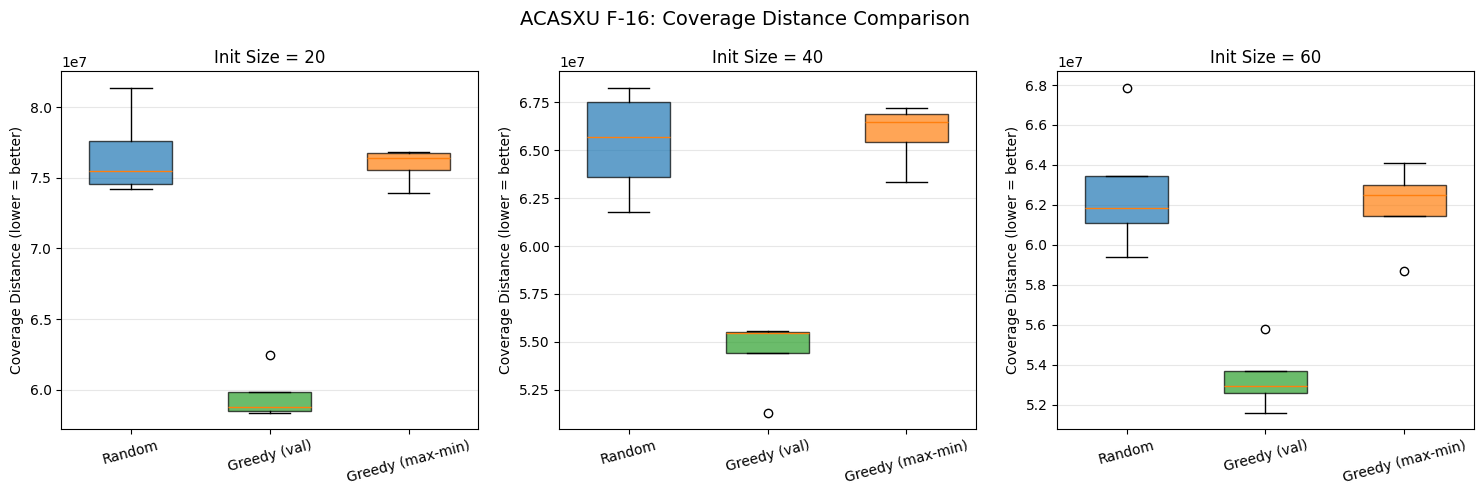

In [17]:
# Visualization
fig, axes = plt.subplots(1, len(init_sizes), figsize=(5 * len(init_sizes), 5))
if len(init_sizes) == 1:
    axes = [axes]

for ax, init_size in zip(axes, init_sizes):
    exp_results = all_experiment_results[init_size]

    methods = ["Random", "Greedy (val)", "Greedy (max-min)"]
    finals = [
        exp_results["random"]["final_coverage"],
        exp_results["greedy_val"]["final_coverage"],
        exp_results["greedy_maxmin"]["final_coverage"],
    ]

    positions = np.arange(len(methods))
    bp = ax.boxplot(finals, positions=positions, widths=0.6, patch_artist=True)

    colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_xticks(positions)
    ax.set_xticklabels(methods, rotation=15)
    ax.set_ylabel("Coverage Distance (lower = better)")
    ax.set_title(f"Init Size = {init_size}")
    ax.grid(axis="y", alpha=0.3)

plt.suptitle("ACASXU F-16: Coverage Distance Comparison", fontsize=14)
plt.tight_layout()
plt.show()